<center><h1>Doshi_Nishi_HW8</h1></center>

Name: Nishi Doshi<br>
Github Username: nishi1612<br>
USC ID: 6494261668

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import softmax

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
wdbc_names = "../data/wdbc.names.txt"

df = pd.read_csv("../data/wdbc.data.csv", header=None)

temp = []
for i in range(len(df.columns)):
    if i == 0:
        temp.append('id')
    elif i == 1:
        temp.append('label')
    else:
        temp.append(f'col{i}')

df.columns = temp
df.replace({'M': 1, 'B': 0}, inplace=True)
df

,id,label,col2,col3,col4,col5,col6,col7,col8,col9,...,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
df['label'].value_counts()

0    357
1    212
Name: label, dtype: int64

### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

In [4]:
def train_test_split_for_dataset(data, random_state, test_size=0.2):
    np.random.seed(random_state)
    b_idx, = np.where(data['label'] == 0)
    b_test_num = round(len(b_idx) * test_size)
    b_test_idx = np.random.choice(b_idx, b_test_num, replace=False)
    m_idx, = np.where(data['label'] == 1)
    m_test_num = round(len(m_idx) * test_size)
    m_test_idx = np.random.choice(m_idx, m_test_num, replace=False)
    test_idx = np.concatenate([b_test_idx, m_test_idx])
    train_idx = np.array([i for i in range(data.shape[0]) if i not in test_idx])
    trainX = data.iloc[train_idx, 2:].copy()
    trainY = data.iloc[train_idx, 1].copy()
    testX = data.iloc[test_idx, 2:].copy()
    testY = data.iloc[test_idx, 1].copy()
    return trainX, testX, trainY, testY

In [5]:
def get_normalized_data(x_train, x_test):    
    normalizer = Normalizer()
    x_train_normalized = normalizer.fit_transform(x_train)
    x_test_normalized = normalizer.fit_transform(x_test)
    return pd.DataFrame(x_train_normalized), pd.DataFrame(x_test_normalized)

In [6]:
def display_single_model_summary(expected_values, predicted_values, predicted_prob, label):
    summary_vals = [accuracy_score(expected_values, predicted_values), confusion_matrix(expected_values, predicted_values)]
    print("Accuracy: ", summary_vals[0])
    print("Confusrion Matrix: ")
    print(summary_vals[1])
    plt.title(f"ROC curve for {label}")
    fpr, tpr, thresholds = roc_curve(expected_values, predicted_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC Curve Area: {round(roc_auc, 4)}")
    point1 = [0, 0]
    point2 = [1, 1]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def evaluate_metrics(data_y, data_y_pred, data_y_pred_prob, results_report):
    fpr, tpr, thresholds = roc_curve(data_y, data_y_pred_prob, pos_label=1)
    return {'acc' : results_report['accuracy'],'precision' : results_report['weighted avg']['precision'],'recall' : results_report['weighted avg']['recall'], 'f1-score' : results_report['weighted avg']['f1-score'], 'auc' : round(auc(fpr, tpr), 4)}

def get_report(clf, data_x, data_y):
    y_data_pred_prob = clf.decision_function(data_x)
    y_data_pred = clf.predict(data_x)
    results_report = classification_report(data_y, y_data_pred, output_dict=True)
    report = evaluate_metrics(data_y, y_data_pred, y_data_pred_prob, results_report)
    return {'tmp_data_res': report, 'y_data_pred': y_data_pred,'y_data_pred_prob': y_data_pred_prob, }

def summarize_results(train_df, test_df):
    train_summary = train_df.apply(lambda x: x.mean(), axis=0)
    test_summary = test_df.apply(lambda x: x.mean(), axis=0)
    data = [train_summary, test_summary]
    summary = pd.concat(data, axis=1)
    summary = summary.T
    summary = summary.set_index(pd.Series(['training', 'test']))
    return summary

def monte_carlo_svm(data, algo):
    if (algo == 'semi-supervised-svm'):
        tuned_params = {'C' : np.logspace(-2, 7, 10)}
    else:
        tuned_params = {'C' : np.logspace(-2, 7, 20)}
    kwargs = {'param_grid' : tuned_params, 'scoring' : 'f1_weighted','n_jobs' : -1,'verbose' : 0}
    cols = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    train_df, test_df = pd.DataFrame(columns=cols), pd.DataFrame(columns=cols)
    table_report = pd.DataFrame(columns = ["Iteration", "Train Accuracy", "Test Accuracy", "Best Parameter Setting"])
    for i in range(30):
        x_train, x_test, y_train, y_test = train_test_split_for_dataset(df, random_state=i)
        x_train, x_test = get_normalized_data(x_train, x_test)
        if (algo == 'supervised-svm'):
            kwargs['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)
            model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **kwargs)
            model.fit(x_train, y_train)
        elif (algo == 'semi-supervised-svm'):
            model = semi_supervised_svm(x_train, y_train, kwargs)
        else:
            model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **kwargs)
            model.fit(x_train, y_train)
        train_report = get_report(model, x_train, y_train)
        test_report = get_report(model, x_test, y_test)
        train_df = train_df.append(train_report['tmp_data_res'], ignore_index=True)
        test_df = test_df.append(test_report['tmp_data_res'], ignore_index=True)
        train_accuracy = train_report['tmp_data_res']['acc']
        test_accuracy = test_report['tmp_data_res']['acc']
        table_report.loc[len(table_report.index)] = [i+1, round(train_accuracy, 4), round(test_accuracy, 4), model.best_params_]
        if (i == 29):
            print("Showing results for 29th iteration: ")
            display_single_model_summary(y_train, train_report['y_data_pred'], train_report['y_data_pred_prob'], "Training")
            display_single_model_summary(y_test, test_report['y_data_pred'], test_report['y_data_pred_prob'], "Testing")
    summary = summarize_results(train_df, test_df)
    return table_report, summary

Showing results for 29th iteration: 
Accuracy:  0.9868421052631579
Confusrion Matrix: 
[[284   2]
 [  4 166]]


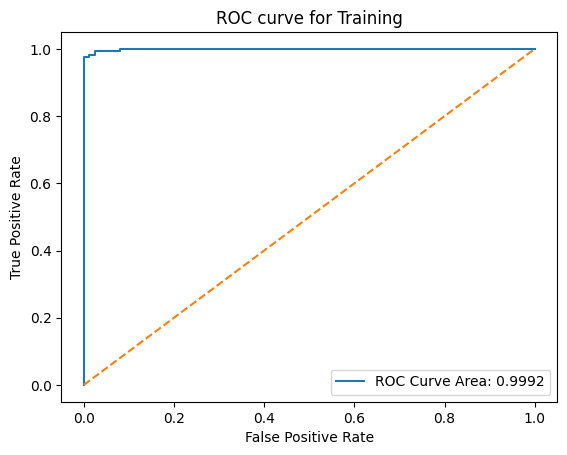

Accuracy:  0.9469026548672567
Confusrion Matrix: 
[[69  2]
 [ 4 38]]


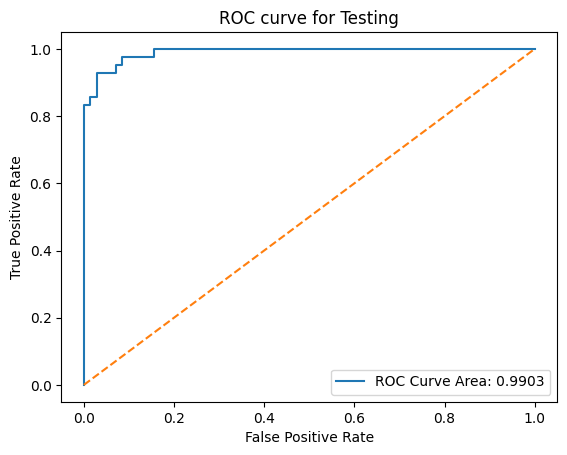

In [7]:
summary = {}
table_report, report_details = monte_carlo_svm(df, 'supervised-svm')

In [8]:
table_report

,Iteration,Train Accuracy,Test Accuracy,Best Parameter Setting
0,1,0.9956,0.9646,{'C': 127427.49857031321}
1,2,0.9759,0.9558,{'C': 1623.776739188721}
2,3,0.9759,0.9204,{'C': 1623.776739188721}
3,4,0.9890,0.9646,{'C': 14384.498882876629}
4,5,0.9978,0.9558,{'C': 42813.32398719387}
5,6,0.9868,0.9469,{'C': 14384.498882876629}
6,7,0.9781,0.9646,{'C': 14384.498882876629}
7,8,0.9846,0.9558,{'C': 42813.32398719387}
8,9,0.9912,0.9735,{'C': 10000000.0}
9,10,0.9737,1.0000,{'C': 4832.930238571752}


In [9]:
summary['Supervized L1 SVM'] = report_details
report_details

,acc,precision,recall,f1-score,auc
training,0.983918,0.983951,0.983918,0.983897,0.998653
test,0.960472,0.960922,0.960472,0.960362,0.988543


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

##### (B)

Showing results for 29th iteration: 
Accuracy:  0.9912280701754386
Confusrion Matrix: 
[[285   1]
 [  3 167]]


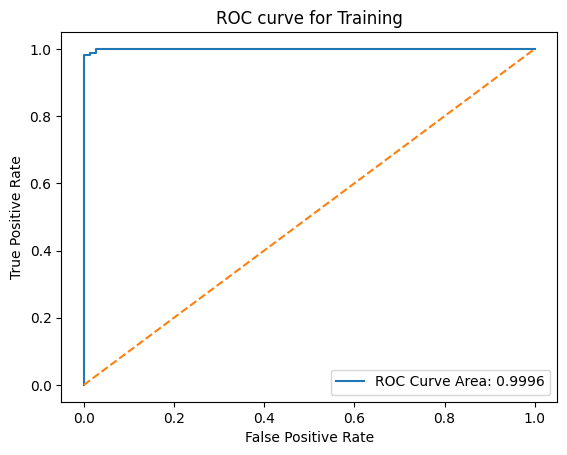

Accuracy:  0.9380530973451328
Confusrion Matrix: 
[[69  2]
 [ 5 37]]


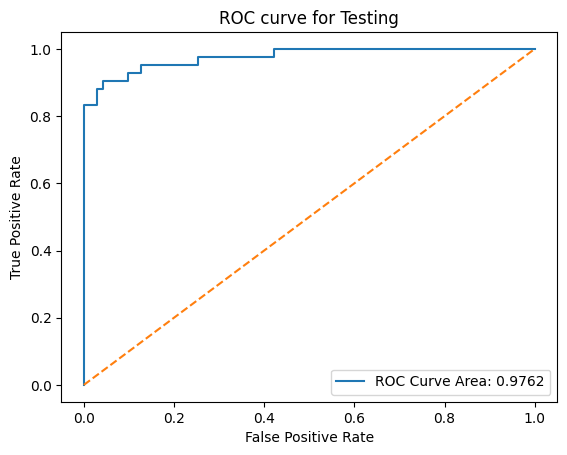

In [10]:
def semi_supervised_svm(x_train, y_train, settings):
    labeled_indx, unlabeled_indx = [], []
    for c in [0, 1]:
        c_idx, = np.where(y_train == c)
        idx_num = round(len(c_idx) * 0.5)
        select_idx = np.random.choice(c_idx, idx_num, replace=False)
        labeled_indx.extend(select_idx)
    for i in range(len(x_train)):
        if i not in labeled_indx:
            unlabeled_indx.append(i)
    x_labeled = x_train.iloc[labeled_indx].to_numpy().tolist()
    y_labeled = y_train.iloc[labeled_indx].to_numpy().tolist()
    x_unlabeled = x_train.iloc[unlabeled_indx].to_numpy().tolist()
    y_unlabeled = y_train.iloc[unlabeled_indx].to_numpy().tolist()
    model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
    model.fit(x_labeled, y_labeled)
    while len(x_unlabeled) > 0:
        scores = model.decision_function(x_unlabeled)
        sorted_idx = sorted([i for i in range(len(x_unlabeled))], key=lambda x : abs(scores[x]))
        x_unlabeled = [x_unlabeled[i] for i in sorted_idx]
        y_unlabeled = [y_unlabeled[i] for i in sorted_idx]
        x_labeled.append(x_unlabeled.pop())
        y_labeled.append(y_unlabeled.pop())
        model.best_estimator_.fit(x_labeled, y_labeled)
    return model

table_report, report_details = monte_carlo_svm(df, 'semi-supervised-svm')

In [11]:
table_report

,Iteration,Train Accuracy,Test Accuracy,Best Parameter Setting
0,1,0.9956,0.9735,{'C': 10000000.0}
1,2,0.9781,0.9735,{'C': 10000.0}
2,3,0.9890,0.9469,{'C': 10000.0}
3,4,0.9956,0.9646,{'C': 1000000.0}
4,5,0.9890,0.9646,{'C': 10000.0}
5,6,0.9846,0.9469,{'C': 10000.0}
6,7,0.9781,0.9646,{'C': 100000.0}
7,8,0.9890,0.9558,{'C': 1000000.0}
8,9,0.9868,0.9646,{'C': 10000.0}
9,10,0.9715,1.0000,{'C': 10000.0}


In [12]:
summary['Semi-Supervized L1 SVM'] = report_details
report_details

,acc,precision,recall,f1-score,auc
training,0.982822,0.982839,0.982822,0.982797,0.998550
test,0.958997,0.959442,0.958997,0.958858,0.987817


#### (iii) Unsupervised Learning

##### (A)

Here we are running the kmeans multiple times and each time the seed value is made new random  value this makes sure that the algorithm does not get trapped in the local minima.

##### (B)

In [13]:
def get_distance(centers, X, cluster_label):
    dist = np.ndarray((X.shape[0],))
    proba = np.ndarray((X.shape[0], 2))
    for i, x in enumerate(X):
        center = centers[cluster_label[i]]
        dist[i] = np.linalg.norm(x - center)
        proba[i, 0] = np.linalg.norm(x - centers[0])
        proba[i, 1] = np.linalg.norm(x - centers[1])
    
    proba = softmax(proba, axis=1).astype(np.float64)
    return dist, proba

def get_majority(X, cluster_label, dist, Y):
    label2cluster = np.ndarray((2,), dtype='int')
    major_label = cluster_label.copy()
    for cluster in [0, 1]:
        sample_idx, = np.where(cluster_label == cluster)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = Y.iloc[top30].value_counts().index[0]
        major_label[sample_idx] = majority
        label2cluster[majority] = cluster
    return label2cluster, major_label

def get_report_unsupervised(dataY, dataPredY, dataPredY_prob):
    dataReport = classification_report(dataY, dataPredY, output_dict = True)
    tmp_data_res = evaluate_metrics(dataY, dataPredY, dataPredY_prob, dataReport)
    return {'data_report': dataReport, 'tmp_data_res': tmp_data_res,'y_data_pred': dataPredY, 'y_data_pred_prob': dataPredY_prob}

def splitData(data, random_state, test_size=0.2):
    np.random.seed(random_state)
    b_idx, = np.where(data['label'] == 0)
    b_test_num = round(len(b_idx) * test_size)
    b_test_idx = np.random.choice(b_idx, b_test_num, replace=False)
    m_idx, = np.where(data['label'] == 1)
    m_test_num = round(len(m_idx) * test_size)
    m_test_idx = np.random.choice(m_idx, m_test_num, replace=False)
    test_idx = np.concatenate([b_test_idx, m_test_idx])
    train_idx = np.array([i for i in range(data.shape[0]) if i not in test_idx])
    trainX = data.iloc[train_idx, 2:].copy()
    trainY = data.iloc[train_idx, 1].copy()
    testX = data.iloc[test_idx, 2:].copy()
    testY = data.iloc[test_idx, 1].copy()
    return trainX, trainY, testX, testY

def normalizeData(trainX, testX):
    scaler = Normalizer()
    norm_trainX = scaler.fit_transform(trainX)
    norm_testX = scaler.transform(testX)
    return norm_trainX, norm_testX

def evalMetrics(ground_truth, predict, prob, dataReport):
    fpr, tpr, thresholds = roc_curve(ground_truth, prob, pos_label = 1)
    roc_auc = round(auc(fpr, tpr), 4)
    return {'acc' : dataReport['accuracy'], 'precision' : dataReport['weighted avg']['precision'], 'recall' : dataReport['weighted avg']['recall'], 'f1-score' : dataReport['weighted avg']['f1-score'], 'auc' : roc_auc}

def monte_carlo_kmeans_spectral(data, algo):
    cols = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    train_resdf = pd.DataFrame(columns=cols)
    test_resdf = pd.DataFrame(columns=cols)
    table_report = pd.DataFrame(columns = ["Iteration", "Train Accuracy", "Test Accuracy"])
    for i in range(30):
        trainX, trainY, testX, testY = splitData(data, random_state = i, test_size=0.2)
        trainX, testX = normalizeData(trainX, testX)
        if algo == 'Unsupervised-KMeans':
            clusterer = KMeans(n_clusters=2, n_init = 15, random_state=i).fit(trainX)
            train_cluster_label = clusterer.predict(trainX)
            dist, trainPredY_prob = get_distance(clusterer.cluster_centers_, trainX, train_cluster_label)
            label2cluster, trainPredY = get_majority(trainX, train_cluster_label, dist, trainY)
        elif algo == 'Unsupervised-Spectral':
            cluster_label = SpectralClustering(n_clusters=2, assign_labels='kmeans', affinity='rbf', eigen_tol = 1e-2, eigen_solver = 'arpack', random_state=0).fit_predict(trainX)
            cluster_centers = []
            for clus in [0,1]:
                cluster_centers.append(np.mean(trainX[cluster_label==clus], axis = 0).tolist())
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(trainX, cluster_label)           
            train_cluster_label = knn.predict(trainX)
            dist, trainPredY_prob = get_distance(cluster_centers, trainX, train_cluster_label)
            label2cluster, trainPredY = get_majority(trainX, train_cluster_label, dist, trainY)    
        pos_cluster = label2cluster[0]
        trainPredY_prob = trainPredY_prob[:, pos_cluster]
        trainReport = classification_report(trainY, trainPredY, output_dict=True)
        tmp_train_res = evalMetrics(trainY, trainPredY, trainPredY_prob, trainReport)
        train_resdf = train_resdf.append(tmp_train_res, ignore_index=True)
        if algo == 'Unsupervised-KMeans':
            test_cluster_label = clusterer.predict(testX)
            dist, testPredY_prob = get_distance(clusterer.cluster_centers_, testX, test_cluster_label)
        elif algo == 'Unsupervised-Spectral':
            test_cluster_label = knn.predict(testX)
            dist, testPredY_prob = get_distance(cluster_centers, testX, test_cluster_label)
        label2cluster, testPredY = get_majority(testX, test_cluster_label, dist, testY)
        pos_cluster = label2cluster[0]
        testPredY_prob = testPredY_prob[:, pos_cluster]
        testReport = classification_report(testY, testPredY, output_dict=True)
        tmp_test_res = evalMetrics(testY, testPredY, testPredY_prob, testReport)
        test_resdf = test_resdf.append(tmp_test_res, ignore_index=True)      
        train_accuracy = trainReport['accuracy']
        test_accuracy = testReport['accuracy']
        table_report.loc[len(table_report.index)] = [i+1, round(train_accuracy, 4), round(test_accuracy, 4)] 
        last_iter_vals = [trainY, trainPredY, trainPredY_prob, testY, testPredY, testPredY_prob]
    summary = summarize_results(train_resdf, test_resdf)
    return table_report, summary, last_iter_vals

table_report, report_details, last_iter_vals = monte_carlo_kmeans_spectral(df, 'Unsupervised-KMeans')

Accuracy:  0.8925438596491229
Confusrion Matrix: 
[[282   4]
 [ 45 125]]


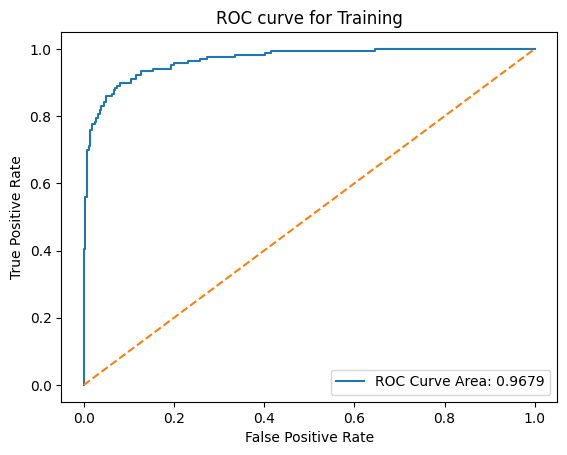

Accuracy:  0.8407079646017699
Confusrion Matrix: 
[[70  1]
 [17 25]]


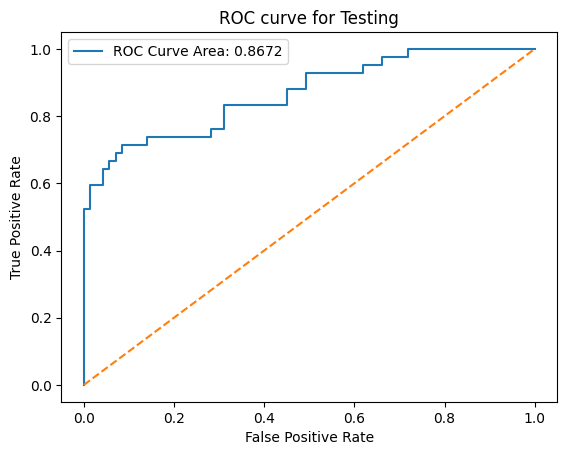

In [14]:
display_single_model_summary(last_iter_vals[0], last_iter_vals[1], last_iter_vals[2], "Training")
display_single_model_summary(last_iter_vals[3], last_iter_vals[4], last_iter_vals[5], "Testing")

In [15]:
table_report

,Iteration,Train Accuracy,Test Accuracy
0,1.0,0.8882,0.8761
1,2.0,0.8706,0.9558
2,3.0,0.8969,0.8496
3,4.0,0.8860,0.9115
4,5.0,0.8991,0.8761
5,6.0,0.8860,0.8673
6,7.0,0.8794,0.8938
7,8.0,0.8860,0.8673
8,9.0,0.8882,0.8584
9,10.0,0.8794,0.8938


In [16]:
summary['Unsupervised KMeans'] = report_details
report_details

,acc,precision,recall,f1-score,auc
training,0.887792,0.896542,0.887792,0.883912,0.950717
test,0.882301,0.894138,0.882301,0.877143,0.945860


#### (iv) Spectral Clustering

In [17]:
table_report, report_details, last_iter_vals = monte_carlo_kmeans_spectral(df, 'Unsupervised-Spectral')

Accuracy:  0.8925438596491229
Confusrion Matrix: 
[[282   4]
 [ 45 125]]


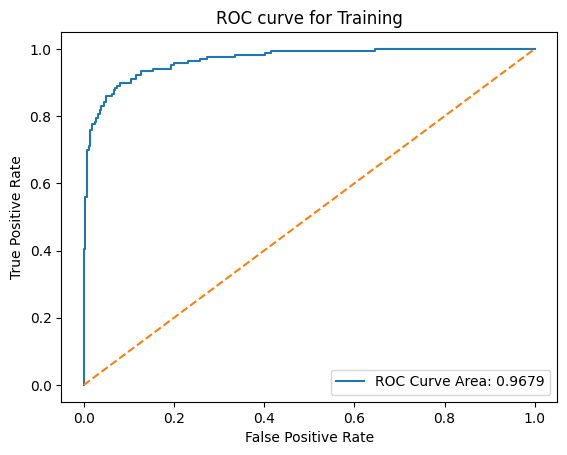

Accuracy:  0.8230088495575221
Confusrion Matrix: 
[[69  2]
 [18 24]]


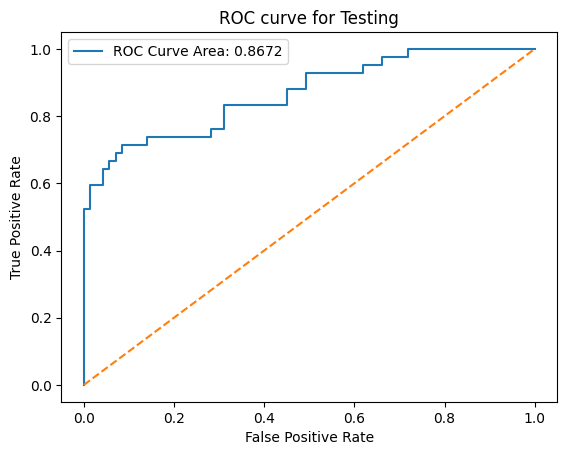

In [18]:
display_single_model_summary(last_iter_vals[0], last_iter_vals[1], last_iter_vals[2], "Training")
display_single_model_summary(last_iter_vals[3], last_iter_vals[4], last_iter_vals[5], "Testing")

In [19]:
table_report

,Iteration,Train Accuracy,Test Accuracy
0,1.0,0.8860,0.8850
1,2.0,0.8684,0.9204
2,3.0,0.8925,0.8407
3,4.0,0.8794,0.8761
4,5.0,0.8838,0.8761
5,6.0,0.8838,0.8761
6,7.0,0.8728,0.8938
7,8.0,0.8838,0.8496
8,9.0,0.8860,0.8496
9,10.0,0.8772,0.8761


In [20]:
summary['Unsupervised-Spectral'] = report_details
report_details

,acc,precision,recall,f1-score,auc
training,0.882895,0.893003,0.882895,0.878464,0.950147
test,0.871681,0.885106,0.871681,0.865377,0.945257


#### (iv) Compare

In [21]:
def summarization():
    for summ in summary.keys():
        print('\n')
        print('='*60)
        print(summ)
        print('='*60)
        print(summary[summ])
summarization()



Supervized L1 SVM
               acc  precision    recall  f1-score       auc
training  0.983918   0.983951  0.983918  0.983897  0.998653
test      0.960472   0.960922  0.960472  0.960362  0.988543


Semi-Supervized L1 SVM
               acc  precision    recall  f1-score       auc
training  0.982822   0.982839  0.982822  0.982797  0.998550
test      0.958997   0.959442  0.958997  0.958858  0.987817


Unsupervised KMeans
               acc  precision    recall  f1-score       auc
training  0.887792   0.896542  0.887792  0.883912  0.950717
test      0.882301   0.894138  0.882301  0.877143  0.945860


Unsupervised-Spectral
               acc  precision    recall  f1-score       auc
training  0.882895   0.893003  0.882895  0.878464  0.950147
test      0.871681   0.885106  0.871681  0.865377  0.945257


## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [22]:
df = pd.read_csv("../data/data_banknote_authentication.txt", header=None)
df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [23]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [24]:
def random_split():    
    test_indx = np.random.choice(df.shape[0], 472, replace=False)
    temp_list = []
    for i in range(df.shape[0]):
        if i not in test_indx:
            temp_list.append(i);
    train_indx = np.array(temp_list)
    return {'train_indx': train_indx,'test_indx': test_indx}

def passive_learning_algorithm(trainX, trainY, testX, testY, settings):
    touse_idx = np.arange(trainX.shape[0])
    used_idx = []
    res_list = []
    while len(touse_idx) > 0:
        np.random.shuffle(touse_idx)
        pool, touse_idx = touse_idx[:10], touse_idx[10:]
        used_idx.extend(pool)       
        used_trainX, used_trainY = trainX.iloc[used_idx], trainY.iloc[used_idx]
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
        clf.fit(used_trainX, used_trainY)
        testPredY = clf.predict(testX)
        test_results = classification_report(testY, testPredY, output_dict=True)
        res_list.append(test_results['accuracy'])
    return res_list

def perform_monte_carlo_simulation(data, algo):
    tuned_params = {'C' : np.logspace(-2, 7, 20)}
    kwargs = {'param_grid' : tuned_params, 'scoring' : 'f1_weighted','n_jobs' : -1,'verbose' : 0}
    learning_curve = []
    table_report = pd.DataFrame(columns = ["Iteration", "Test accuracy (10 samples)", "Test accuracy (900 samples)"])
    for i in range(50):
        index = random_split()
        train_idx = index['train_indx']
        test_idx = index['test_indx']
        train_set, test_set = data.iloc[train_idx], data.iloc[test_idx]
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        trainX, testX = get_normalized_data(trainX, testX)
        kwargs['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)
        if (algo == 'passive'):            
            acc_list = passive_learning_algorithm(trainX, trainY, testX, testY, kwargs)
            learning_curve.append(acc_list)
        elif (algo == 'active'):
            acc_list = active_learning_algorithm(trainX, trainY, testX, testY, kwargs)
            learning_curve.append(acc_list)
        table_report.loc[len(table_report.index)] = [int(i+1), round(acc_list[0], 4), round(acc_list[-1], 4)]
    learning_curve = np.array(learning_curve)
    learning_curve = np.mean(learning_curve, axis=0)
    return learning_curve, table_report

In [25]:
passive_learning_curve, table_report = perform_monte_carlo_simulation(df, 'passive')
table_report

,Iteration,Test accuracy (10 samples),Test accuracy (900 samples)
0,1.0,0.6419,0.9958
1,2.0,0.7987,0.9915
2,3.0,0.8453,0.9936
3,4.0,0.8835,0.9915
4,5.0,0.7034,0.9894
5,6.0,0.9174,0.9936
6,7.0,0.8242,0.9958
7,8.0,0.6398,0.9936
8,9.0,0.9852,0.9979
9,10.0,0.9492,0.9958


#### (ii) Active

In [26]:
def active_learning_algorithm(trainX, trainY, testX, testY, settings):
    touse_idx = np.arange(trainX.shape[0])
    used_idx = []
    res_list = []   
    np.random.shuffle(touse_idx)
    pool, touse_idx = touse_idx[:10], touse_idx[10:]
    used_idx.extend(pool)
    while len(used_idx) <= 900:
        used_trainX, used_trainY = trainX.iloc[used_idx], trainY.iloc[used_idx]
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
        clf.fit(used_trainX, used_trainY)
        testPredY = clf.predict(testX)
        test_results = classification_report(testY, testPredY, output_dict=True)
        res_list.append(test_results['accuracy'])
        if len(touse_idx) == 0:
            break
        dist = clf.decision_function(trainX.iloc[touse_idx])
        sortedarg = np.arange(len(touse_idx))
        sorted(sortedarg, key=lambda i : abs(dist[i]))
        touse_idx = touse_idx[sortedarg]
        pool, touse_idx = touse_idx[:10], touse_idx[10:]
        used_idx.extend(pool)
    return res_list

In [27]:
active_learning_curve, table_report = perform_monte_carlo_simulation(df, 'active')
table_report

,Iteration,Test accuracy (10 samples),Test accuracy (900 samples)
0,1.0,0.9788,0.9915
1,2.0,0.8432,0.9979
2,3.0,0.7076,0.9958
3,4.0,0.8538,0.9936
4,5.0,0.4470,0.9936
5,6.0,0.7246,0.9873
6,7.0,0.8220,0.9936
7,8.0,0.9619,0.9915
8,9.0,0.6843,0.9936
9,10.0,0.8729,0.9958


### (c) Average the 50 test errors

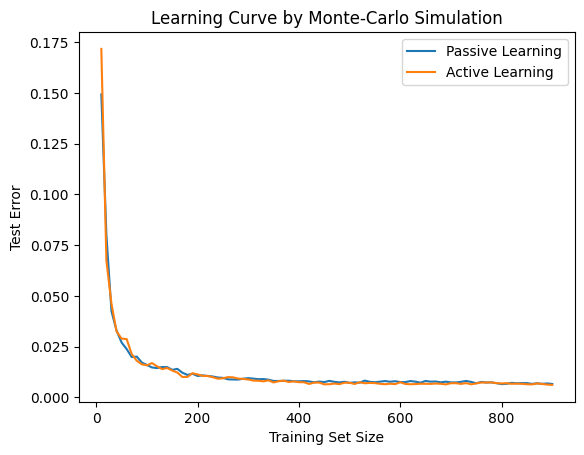

In [28]:
plt.title(f"Learning Curve by Monte-Carlo Simulation")
x = 10 * np.arange(1, 91)
plt.plot(x, 1 - passive_learning_curve, label='Passive Learning')
plt.plot(x, 1 - active_learning_curve, label='Active Learning')
plt.xlabel("Training Set Size")
plt.ylabel("Test Error")
plt.legend()
plt.show()

### References

1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering